<a href="https://colab.research.google.com/github/smaugcow/test_test/blob/main/lab1_ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
from torchvision.models import ResNet50_Weights

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(3235)

EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT_DIRECTORY = '/content/drive/MyDrive/data'
CLASSES = sorted(os.listdir(ROOT_DIRECTORY))

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=ROOT_DIRECTORY)
all_image_paths = [sample[0] for sample in full_dataset.samples]
all_labels = [sample[1] for sample in full_dataset.samples]

train_indices = []
validation_indices = []
test_indices = []

for class_index in range(len(CLASSES)):
    class_indices = [i for i, label in enumerate(all_labels) if label == class_index]

    random.shuffle(class_indices)

    train_size = int(0.7 * len(class_indices))
    validation_size = int(0.2 * len(class_indices))
    test_size = len(class_indices) - train_size - validation_size

    train_indices.extend(class_indices[:train_size])
    validation_indices.extend(class_indices[train_size:train_size + validation_size])
    test_indices.extend(class_indices[train_size + validation_size:])
    print(f"Class {CLASSES[class_index]}: Train={train_size}, Validation={validation_size}, Test={test_size}")

train_dataset = datasets.ImageFolder(root=ROOT_DIRECTORY, transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=ROOT_DIRECTORY, transform=valid_test_transforms)
test_dataset = datasets.ImageFolder(root=ROOT_DIRECTORY, transform=valid_test_transforms)

training_subset = Subset(train_dataset, train_indices)
validation_subset = Subset(validation_dataset, validation_indices)
test_subset = Subset(test_dataset, test_indices)

training_loader = DataLoader(dataset=training_subset,
                             batch_size=128,
                             shuffle=True)

validation_loader = DataLoader(dataset=validation_subset,
                                   batch_size=16,
                               shuffle=True)

test_loader = DataLoader(dataset=test_subset,
                         batch_size=1,
                         shuffle=True)

relu_model = torchvision.models.resnet50(
    weights=ResNet50_Weights.IMAGENET1K_V1)
relu_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(relu_model.fc.in_features, len(CLASSES)))

Class alpaca: Train=70, Validation=20, Test=10
Class cat: Train=70, Validation=20, Test=10
Class dog: Train=70, Validation=20, Test=10
Class flower: Train=70, Validation=20, Test=10
Class fox: Train=70, Validation=20, Test=10
Class horses: Train=70, Validation=20, Test=10
Class jellyfish: Train=70, Validation=20, Test=10
Class monkey: Train=70, Validation=20, Test=10
Class panda: Train=70, Validation=20, Test=10
Class toad: Train=70, Validation=20, Test=10


In [5]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [6]:
square_model = torchvision.models.resnet50(
    weights=ResNet50_Weights.IMAGENET1K_V1)

In [7]:
for child_name, child_module in square_model.named_children():
    if isinstance(child_module, torchvision.models.resnet.BasicBlock):
        child_module.relu = nn.Sequential(
            nn.Identity(),
            Lambda(lambda x: x**2)
        )
    elif isinstance(child_module, nn.ReLU):
        setattr(square_model, child_name, nn.Sequential(
            nn.Identity(),
            Lambda(lambda x: x**2)
        ))
square_model.fc = nn.Sequential(
    nn.Linear(square_model.fc.in_features, 256),
    Lambda(lambda x: x**2),
    nn.Dropout(0.5),
    nn.Linear(256, len(CLASSES)),
    #Lambda(lambda x: x**2)
    nn.Softmax(dim=1)
)

loss_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
loss_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(loss_model.fc.in_features, len(CLASSES)))

square_loss_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [8]:
for child_name, child_module in square_loss_model.named_children():
    if isinstance(child_module, torchvision.models.resnet.BasicBlock):
        child_module.relu = nn.Sequential(
            nn.Identity(),
            Lambda(lambda x: x**2)
        )
    elif isinstance(child_module, nn.ReLU):
        setattr(square_loss_model, child_name, nn.Sequential(
            nn.Identity(),
            Lambda(lambda x: x**2)
        ))
square_loss_model.fc = nn.Sequential(
    nn.Linear(square_loss_model.fc.in_features, 256),
    Lambda(lambda x: x**2),
    nn.Dropout(0.5),
    nn.Linear(256, len(CLASSES)),
    #Lambda(lambda x: x**2)
    nn.Softmax(dim=1)
)


def accuracy(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    correct_predictions = (predicted_labels == labels).sum().item()
    accuracy = correct_predictions / labels.size(0)
    return accuracy

In [9]:
def train(model, isLossModel):
    model = model.to(DEVICE)
    criterion = nn.MSELoss() if isLossModel else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        model = model.train()
        batch_training_loss = []
        batch_training_accuracy = []

        for i, (images, labels) in enumerate(training_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)

            current_labels = F.one_hot(labels, num_classes=len(CLASSES)).float() if isLossModel else labels
            current_loss = criterion(outputs, current_labels)
            current_accuracy = accuracy(outputs, labels)

            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()

            batch_training_loss.append(current_loss.item())
            batch_training_accuracy.append(current_accuracy)

        epoch_training_loss = np.mean(batch_training_loss)
        epoch_training_accuracy = np.mean(batch_training_accuracy)

        print(f"Training: Loss: {epoch_training_loss:.4f}, Accuracy: {epoch_training_accuracy*100:.2f}%")

        training_losses.append(epoch_training_loss)
        training_accuracies.append(epoch_training_accuracy)

        #Validation

        batch_validation_loss = 0.0
        batch_validation_accuracy = 0.0

        with torch.no_grad():
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(images)
                current_labels = F.one_hot(labels, num_classes=len(CLASSES)).float() if isLossModel else labels
                current_loss = criterion(outputs, current_labels)
                current_accuracy = accuracy(outputs, labels)

                batch_validation_loss += current_loss.item()
                batch_validation_accuracy += current_accuracy

        epoch_validation_loss = batch_validation_loss / len(validation_loader)
        epoch_validation_accuracy = batch_validation_accuracy / len(validation_loader)

        print(f"Validation: Loss: {epoch_validation_loss:.4f}, Accuracy: {epoch_validation_accuracy*100:.2f}%")

        validation_losses.append(epoch_validation_loss)
        validation_accuracies.append(epoch_validation_accuracy)

    print('Training finished')
    return (training_losses, training_accuracies, validation_losses, validation_accuracies)

In [10]:
print("Training ReLu + CrossEntropyLoss")
relu_training_losses, relu_training_accuracies, relu_validation_losses, relu_validation_accuracies = train(relu_model, False)
print("Training Square + CrossEntropyLoss")
square_training_losses, square_training_accuracies, square_validation_losses, square_validation_accuracies = train(square_model, False)
print("Training ReLu + MSELoss")
loss_training_losses, loss_training_accuracies, loss_validation_losses, loss_validation_accuracies = train(loss_model, True)
print("Training Square + MSELoss")
square_loss_training_losses, square_loss_training_accuracies, square_loss_validation_losses, square_loss_validation_accuracies = train(square_loss_model, True)

Training ReLu + CrossEntropyLoss
Epoch 1/10
Training: Loss: 2.1939, Accuracy: 19.80%
Validation: Loss: 1.7616, Accuracy: 55.29%
Epoch 2/10
Training: Loss: 1.5973, Accuracy: 52.78%
Validation: Loss: 1.3650, Accuracy: 79.33%
Epoch 3/10
Training: Loss: 1.2184, Accuracy: 67.95%
Validation: Loss: 1.0479, Accuracy: 92.31%
Epoch 4/10
Training: Loss: 0.8435, Accuracy: 80.05%
Validation: Loss: 0.8862, Accuracy: 87.98%
Epoch 5/10
Training: Loss: 0.6324, Accuracy: 81.95%
Validation: Loss: 0.6547, Accuracy: 91.83%
Epoch 6/10
Training: Loss: 0.5109, Accuracy: 84.98%
Validation: Loss: 0.5652, Accuracy: 92.79%
Epoch 7/10
Training: Loss: 0.3841, Accuracy: 88.24%
Validation: Loss: 0.4435, Accuracy: 94.71%
Epoch 8/10
Training: Loss: 0.2886, Accuracy: 91.06%
Validation: Loss: 0.4634, Accuracy: 91.35%
Epoch 9/10
Training: Loss: 0.2699, Accuracy: 92.38%
Validation: Loss: 0.4022, Accuracy: 94.71%
Epoch 10/10
Training: Loss: 0.2087, Accuracy: 94.37%
Validation: Loss: 0.3462, Accuracy: 95.67%
Training finishe

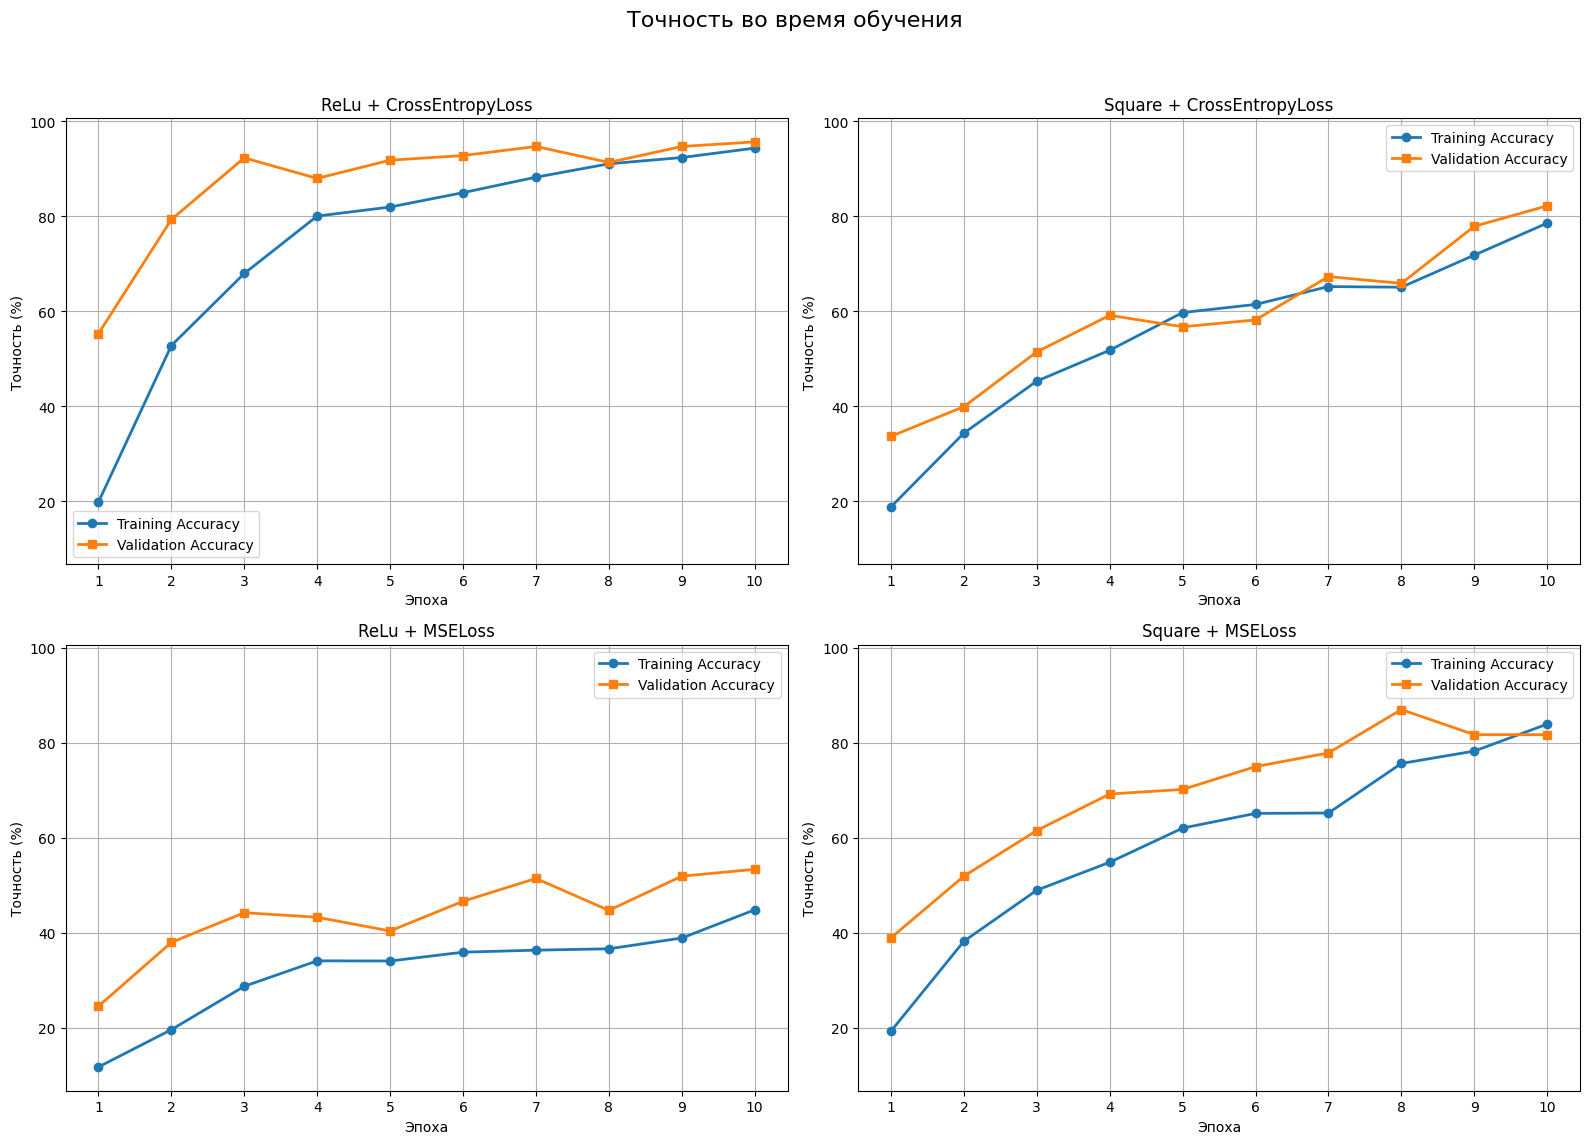

In [11]:
all_accuracies = [
    relu_training_accuracies, relu_validation_accuracies,
    square_training_accuracies, square_validation_accuracies,
    loss_training_accuracies, loss_validation_accuracies,
    square_loss_training_accuracies, square_loss_validation_accuracies
]

all_acc_percent = [np.array(acc) * 100 for acc in all_accuracies]
min_accuracy = min([min(acc) for acc in all_acc_percent]) - 5
max_accuracy = max([max(acc) for acc in all_acc_percent]) + 5

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Точность во время обучения', fontsize=16)

for ax in axs.flat:
    ax.set(xlabel='Эпоха', ylabel='Точность (%)')
    ax.set_ylim(min_accuracy, max_accuracy)
    ax.grid(True)
    ax.set_xticks(range(1, EPOCHS+1))

titles = ['ReLu + CrossEntropyLoss', 'Square + CrossEntropyLoss', 'ReLu + MSELoss', 'Square + MSELoss']
for i, (ax, title) in enumerate(zip(axs.flat, titles)):
    train_idx = i * 2
    val_idx = i * 2 + 1

    ax.plot(range(1, EPOCHS+1), all_acc_percent[train_idx],
            label='Training Accuracy', marker='o', linewidth=2)
    ax.plot(range(1, EPOCHS+1), all_acc_percent[val_idx],
            label='Validation Accuracy', marker='s', linewidth=2)
    ax.set_title(title, fontsize=12)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

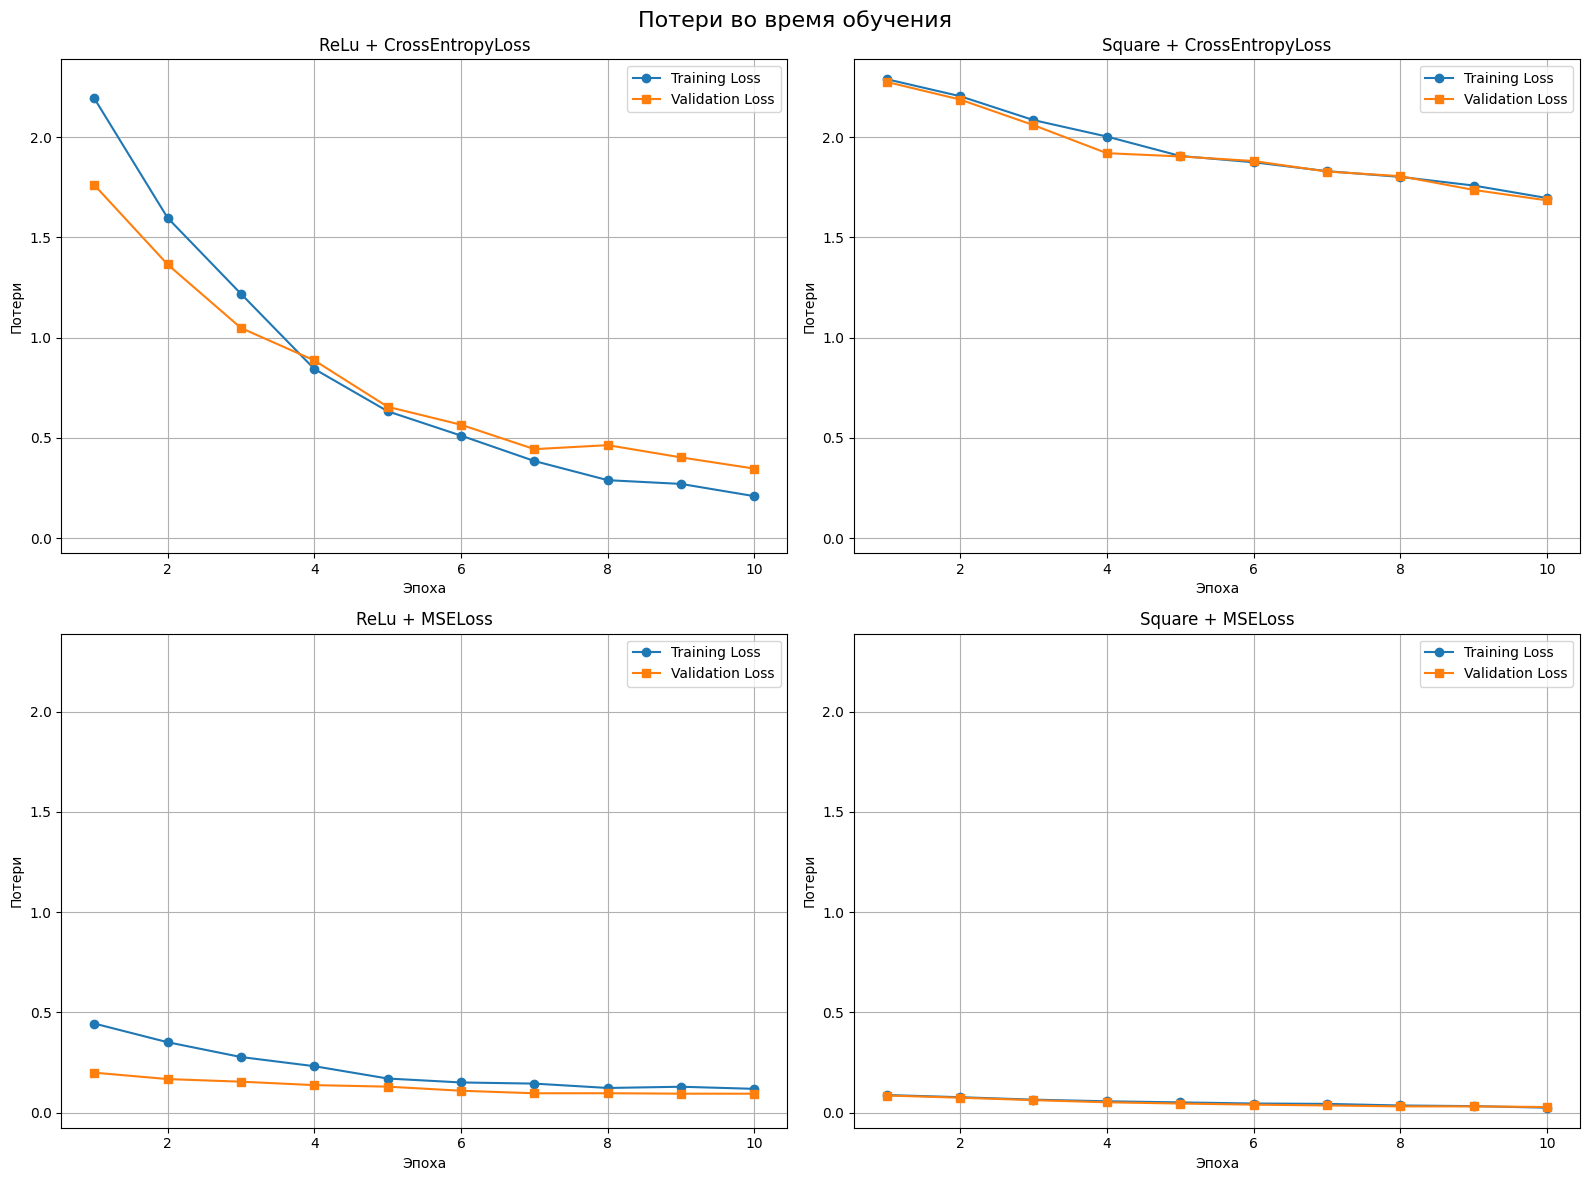

In [12]:
all_losses = [
    relu_training_losses, relu_validation_losses,
    square_training_losses, square_validation_losses,
    loss_training_losses, loss_validation_losses,
    square_loss_training_losses, square_loss_validation_losses
]
min_loss = min([min(loss) for loss in all_losses])
max_loss = max([max(loss) for loss in all_losses])

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Потери во время обучения', fontsize=16)

for ax in axs.flat:
    ax.set(xlabel='Эпоха', ylabel='Потери')
    ax.set_ylim(min_loss - 0.1, max_loss + 0.1)
    ax.grid(True)

titles = ['ReLu + CrossEntropyLoss', 'Square + CrossEntropyLoss', 'ReLu + MSELoss', 'Square + MSELoss']
for i, (ax, title) in enumerate(zip(axs.flat, titles)):
    train_idx = i * 2
    val_idx = i * 2 + 1

    ax.plot(range(1, EPOCHS+1), all_losses[train_idx],
            label='Training Loss', marker='o')
    ax.plot(range(1, EPOCHS+1), all_losses[val_idx],
            label='Validation Loss', marker='s')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

In [13]:
def test(model, isLossModel):
    criterion = nn.MSELoss() if isLossModel else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_accuracy = 0.0
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            current_labels = F.one_hot(labels, num_classes=len(CLASSES)).float() if isLossModel else labels
            current_loss = criterion(outputs, current_labels)
            current_accuracy = accuracy(outputs, labels)
            epoch_test_loss += current_loss.item()
            epoch_test_accuracy += current_accuracy

            _, predicted_labels = torch.max(outputs, 1)

            for predict in predicted_labels:
                predictions.append([labels[0], predict.item()])

    test_loss = epoch_test_loss / len(test_loader)
    test_accuracy = epoch_test_accuracy / len(test_loader)
    print(f"Testing: Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%")
    return (test_loss,test_accuracy)

In [14]:
print("ReLu + CrossEntropyLoss")
test(relu_model, False)
print("Square + CrossEntropyLoss")
test(square_model, False)
print("ReLu + MSELoss")
test(loss_model, True)
print("Square + MSELoss")
test(square_loss_model, True)

ReLu + CrossEntropyLoss
Testing: Loss: 0.2377, Accuracy: 98.00%
Square + CrossEntropyLoss
Testing: Loss: 1.6242, Accuracy: 87.00%
ReLu + MSELoss
Testing: Loss: 0.0467, Accuracy: 95.00%
Square + MSELoss
Testing: Loss: 0.0178, Accuracy: 94.00%


(0.017849327969022034, 0.94)